### Cumulative Grade Point Average (CGPA).

In this notebook we are going to create a machine learning model that will be able to predict students' `Cumulative Grade Point Average (CGPA)` using the dataset that was obtained on kaggle [`University Students' Mental Health`](https://www.kaggle.com/datasets/junnn0126/university-students-mental-health).

> **About the dataset:** This Data set was collected by a survey conducted by Google forms from Malaysia University student in order to examine their current academic situation and mental health. https://www.kaggle.com/datasets/junnn0126/university-students-mental-health

We are going to evaluate different Machine learning Algorithims not limmited to the following:

1. `DecisionTreeRegressor`
2. `SVR`
3. `RandomForestRegressor`
4. `LinearRegression`
5. `KNeighborsRegressor`

We are going to choose the best algorithm to perform a regression task on predicting the `CGPA` of a student using the following variables:

1. **Basic**
    - `Gender`	
    - `Age`
    - `YearOfStudy`

2. **Target:**
    - `CGPA`	

3. **Health:**
    - `Depression`	
    - `Anxiety`	
    - `PanicAttack`	
    - `SpecialistTreatment`	
    - `SymptomFrequency_Last7Days`	
    - `HasMentalHealthSupport`	

4. **Others:**
    - `SleepQuality`	
    - `StudyStressLevel`	
    - `StudyHoursPerWeek`	
    - `AcademicEngagement`

### Import of modules

In the following code cell we are going to import all the packages that are going to be used in this notebook.


In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
import random

from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import xgboost as xgb

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)

pandas: 2.1.4
numpy: 1.26.4
xgb: 2.1.2


### Seed
Next we are going to set the seed for all random operations for reproducivity of results in this notebook.

In [114]:
SEED = 17

np.random.seed(SEED)
random.seed(SEED)

### Data
In the following code cell we are going to define the path to where the data is located.

In [117]:
path = "mentalhealth_dataset.csv"

Next we are going to read the data into a pandas dataframe.

In [120]:
data = pd.read_csv(path)
data.head(2)

,Timestamp,Gender,Age,Course,YearOfStudy,CGPA,Depression,Anxiety,PanicAttack,SpecialistTreatment,SymptomFrequency_Last7Days,HasMentalHealthSupport,SleepQuality,StudyStressLevel,StudyHoursPerWeek,AcademicEngagement
0,13/7/2020,Female,24,Biotechnology,Year 3,2.38,1,0,0,0,5,0,4,5,8,2
1,13/7/2020,Female,18,Biotechnology,Year 3,4.00,0,1,0,0,0,0,4,4,13,5


In the next code cell we are going to drop the `Timestame` and `Course` columns in the dataset since they don't have much impact on the prediction of student's `CGPA`.

In [123]:
data.drop(columns=['Timestamp', 'Course'], inplace=True) 

Then we are going to convert the `YearOfStudy` to a common case.

In [126]:
data.YearOfStudy = data.YearOfStudy.apply(lambda x: x.upper())

In the following code cell we are going to drop all `na` values that might exists in columns of this dataset. 

In [129]:
if any(data.isna().any()):
    data.dropna(inplace=True)

### Constants
In the following code cell we are going to define some constants that we are going to use throughout this notebook.

In [132]:
COLORS = ["#B33791", "#4DA8DA", "#075B5E", "#131D4F", "#52357B", "#FF0B55", "#7F8CAA", "#D5451B", "#4B352A", "#2A4759"]

### Data Analysis.
In this section of the notebook we are going to analyse the data that we have. 


#### 1. Relational Plots

In the following code cell we are going to plot the relational plots of categorical features in the dataset using the countplot.

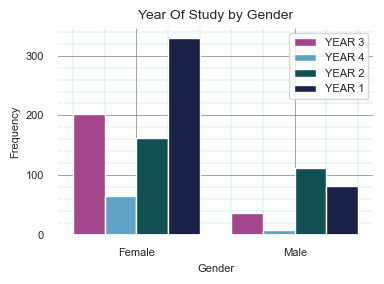

In [135]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=data, hue="YearOfStudy", x="Gender", palette=COLORS[:6])
plt.xlabel("Gender", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.legend(fontsize=8)
plt.title("Year Of Study by Gender", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()


In the following code cell we are going to plot the density of gender and some numerical variables.

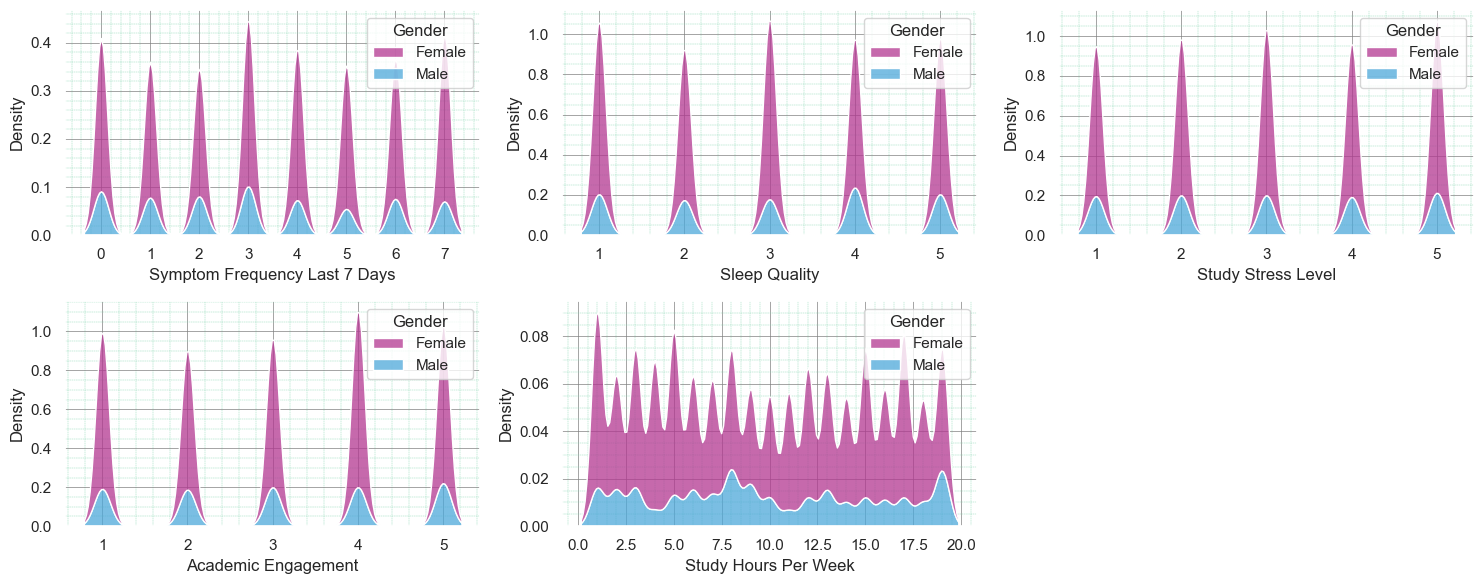

In [137]:
sns.set(font_scale=0.8)
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharey=False)
axes = axes.flatten()

sns.kdeplot(
    data=data,
    x="SymptomFrequency_Last7Days",
    hue="Gender",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=COLORS,
    ax=axes[0]
)
axes[0].set(xlabel="Symptom Frequency Last 7 Days")
axes[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[0].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[0].minorticks_on()

sns.kdeplot(
    data=data,
    x="SleepQuality",
    hue="Gender",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=COLORS,
    ax=axes[1]
)
axes[1].set(xlabel="Sleep Quality")
axes[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[1].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[1].minorticks_on()

sns.kdeplot(
    data=data,
    x="StudyStressLevel",
    hue="Gender",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=COLORS,
    ax=axes[2]
)
axes[2].set(xlabel="Study Stress Level")
axes[2].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[2].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[2].minorticks_on()

sns.kdeplot(
    data=data,
    x="AcademicEngagement",
    hue="Gender",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=COLORS,
    ax=axes[3]
)
axes[3].set(xlabel="Academic Engagement")
axes[3].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[3].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[3].minorticks_on()

sns.kdeplot(
    data=data,
    x="StudyHoursPerWeek",
    hue="Gender",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=COLORS,
    ax=axes[4]
)
axes[4].set(xlabel="Study Hours Per Week")
axes[4].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[4].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[4].minorticks_on()
axes[5].axis("off")

plt.tight_layout()
plt.show()


### Splitting the data into 2 sets

In the following code cell we are going to split the data into 2 sets which are `train` and `test`.

In [139]:
train, test = train_test_split(
    data, test_size=0.15, random_state=SEED
)

Next we are going to check the distribution of data in each set.

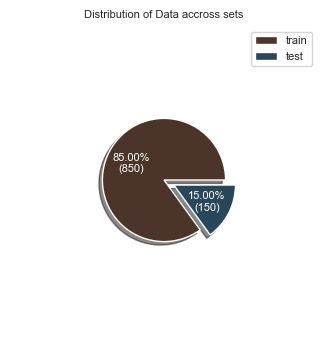

In [142]:
dist_sets = {'train': len(train), 'test': len(test)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(data)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=COLORS[-2:], shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### Extracting features and Labels

In the next code cell we are going to extract features and labels from our dataset. We are going to have `CGPA` as our target label.

For both training and testing dataset. After extracting the labels we are going to transform them.

In [144]:
y_train = train.CGPA.values
y_test = test.CGPA.values

In [145]:
y_train[:2]

array([2.99, 3.65])

In [146]:
y_test[:2]

array([2.95, 3.35])

In the next code cell we are going to define the scaler for our labels.

In [148]:
scaler = StandardScaler()

In the next code cell we are then going to transform our labels using the `StandardScaler` created above.

In [150]:
def scale_labels(scaler, train, test):
    train = scaler.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), scaler.transform(test.reshape(-1, 1)).reshape(-1)

train_cgpa, test_cgpa = scale_labels(scaler, y_train, y_test)

In the following code cell we are going to remove `CGPA` so that we extract our features.

In [152]:
train.drop(columns=["CGPA"], inplace=True)
test.drop(columns=["CGPA"], inplace=True)

For all the non-binary numerical column, we are going to use the `StandardScaler` and for the none numerical columns we are going to start by using the `Ordinal` scaler to convert them to numbers and then we scale non-binary columns using the `StandardScaler`.

In [154]:
encode_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder())
])

encode_standardize_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('min_max_scaler', MinMaxScaler())
])

scale_pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

ct = ColumnTransformer([
    ("categorical pre-processing", encode_pipeline, ["Gender"]),
    ("categorical pre-processing-twice", encode_standardize_pipeline, ["YearOfStudy"]),
    ("numerical pre-processing", scale_pipeline, [
        "Age", "SleepQuality", "StudyStressLevel",
        "StudyHoursPerWeek", "AcademicEngagement",
        "SymptomFrequency_Last7Days"
    ])
], remainder='passthrough')
train_features = ct.fit_transform(train)
test_features = ct.transform(test)

In [155]:
test_features[0]

array([1.        , 0.33333333, 0.85714286, 0.        , 1.        ,
       0.33333333, 0.75      , 0.14285714, 0.        , 0.        ,
       1.        , 0.        , 0.        ])

### Feature Impotance 

In the following code cell we are going to create a function that will use the `XGBRegressor` algorithm to compute feature how important is for each feature in predicting `CGPA` of students.  

In [157]:
def get_feature_impotance(train_features, train_labels, test_features, test_labels):
    xgb_model = xgb.XGBRegressor(
        base_score=0.5, 
        booster='gbtree',    
        n_estimators=1000,  
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    xgb_model.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        verbose=100
   )
    return xgb_model.feature_importances_

Next we are going to get all the features importance array for the `cgpa`.

In [159]:
fi = get_feature_impotance(train_features, train_cgpa, test_features, test_cgpa)

[0]	validation_0-rmse:1.10774	validation_1-rmse:1.08339
[100]	validation_0-rmse:0.48139	validation_1-rmse:0.46062
[200]	validation_0-rmse:0.29005	validation_1-rmse:0.27757
[300]	validation_0-rmse:0.24020	validation_1-rmse:0.23405
[400]	validation_0-rmse:0.22287	validation_1-rmse:0.22215
[500]	validation_0-rmse:0.21318	validation_1-rmse:0.21861
[600]	validation_0-rmse:0.20687	validation_1-rmse:0.21827
[646]	validation_0-rmse:0.20462	validation_1-rmse:0.21826


Next we are going to create a dataframe that we are going to use to plot the feature importance, for `cgpa`.

In [161]:
cgpa_fi = pd.DataFrame(
    data=fi,
    index=train.columns,
    columns=['importance']
)
cgpa_fi.head()

,importance
Gender,0.006369
Age,0.010326
YearOfStudy,0.007118
Depression,0.015719
Anxiety,0.006559


In the following code cell we are going how important is each feature in predicting `cgpa`.

<Figure size 400x200 with 0 Axes>

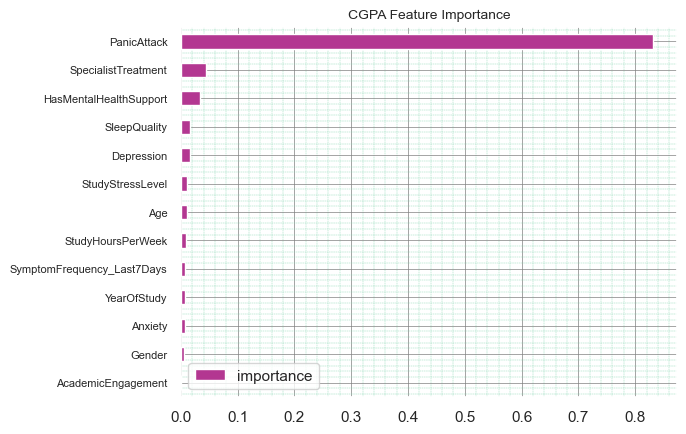

In [163]:

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))

cgpa_fi.sort_values('importance').plot(kind='barh', color=COLORS)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.yticks(fontsize=8)
plt.title('CGPA Feature Importance', fontsize=10)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

> We can see that `Accademic Engagement` does not have a huge impact on predcting `cgpa`.


### Model Selection

In the following code cell we are going to train `5` Regression Algorithm so that we can see which one will perform better among:

1. `Linear Regression (LR)`
2. `Decision Tree Regressor (DTR)`
3. `Random Forest Regressor (RFR)`
4. `Support Vector Regressor (SVR)`
5. `K-Neighbors Regressor (KNR)`


We are going to evaluate the models/algorithims so that we choose the best model for this task.

In [165]:
pipeline_lr = Pipeline([('lr_regressor', LinearRegression())])
pipeline_dt = Pipeline([ ('dt_regressor', DecisionTreeRegressor())])
pipeline_rf = Pipeline([('rf_regressor', RandomForestRegressor())])
pipeline_svr = Pipeline([('sv_regressor', SVR())])
pipeline_knn = Pipeline([('knn_regressor', KNeighborsRegressor())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svr, pipeline_knn]
pipe_dict = {0: 'LR', 1: 'DTR', 2: 'RFR', 3: "SVR", 4: 'KNR'}

def get_scores(X_train, y_train, X_test, y_test):
    for pipe in pipelines:
        pipe.fit(X_train, y_train)
    
    scores = []
    for i, model in enumerate(pipelines):
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse =  mean_squared_error(y_test, y_pred)
        rscore = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        score = {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore, 'regressor': pipe_dict[i]
        }
        scores.append(score)
    return scores

Next we are going to get the scores for `cgpa` and see which algorithm perfoms better.

In [167]:
scores = get_scores(train_features, train_cgpa, test_features, test_cgpa)

In [168]:
scores

[{'mae': 0.269000852389379,
  'mse': 0.10344987145399986,
  'rmse': 0.3216362408902328,
  'r2-score': 0.8959526711800404,
  'regressor': 'LR'},
 {'mae': 0.19586306434275627,
  'mse': 0.10563848025663018,
  'rmse': 0.3250207381947038,
  'r2-score': 0.8937514224346826,
  'regressor': 'DTR'},
 {'mae': 0.14917496697339613,
  'mse': 0.051590941939183746,
  'rmse': 0.22713639501230037,
  'r2-score': 0.9481111032364637,
  'regressor': 'RFR'},
 {'mae': 0.2476681768418457,
  'mse': 0.09462197205348472,
  'rmse': 0.3076068465647095,
  'r2-score': 0.9048315546315617,
  'regressor': 'SVR'},
 {'mae': 0.48710864532598047,
  'mse': 0.36587177004569627,
  'rmse': 0.6048733504178344,
  'r2-score': 0.6320151989670422,
  'regressor': 'KNR'}]

In [169]:
scores_df  = pd.DataFrame(scores)
scores_df

,mae,mse,rmse,r2-score,regressor
0,0.269001,0.103450,0.321636,0.895953,LR
1,0.195863,0.105638,0.325021,0.893751,DTR
2,0.149175,0.051591,0.227136,0.948111,RFR
3,0.247668,0.094622,0.307607,0.904832,SVR
4,0.487109,0.365872,0.604873,0.632015,KNR


Next we are going to scale our metrics using the `MinMaxScaler` so that they can be plotted on the same axis with a minimum value of 0 and maximum value of 1.

In [171]:
def scale_scores(x, pipeline):
    return pipeline.fit_transform(x.values.reshape(-1, 1)).squeeze()

score_scale_pipeline = MinMaxScaler()

scores_df['mae'] = scale_scores(scores_df['mae'], score_scale_pipeline)
scores_df['mse'] = scale_scores(scores_df['mse'], score_scale_pipeline)
scores_df['rmse'] = scale_scores(scores_df['rmse'], score_scale_pipeline)
scores_df['r2-score'] = scale_scores(scores_df['r2-score'], score_scale_pipeline)

<Figure size 400x300 with 0 Axes>

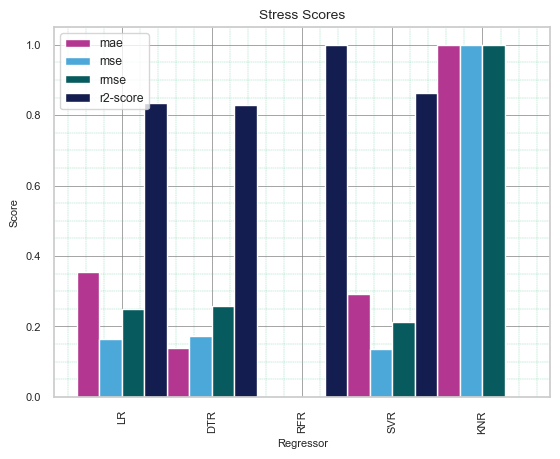

In [172]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")

plt.figure(figsize=(4, 3))

scores_df.plot(
    x='regressor', kind='bar', stacked=False,
    fontsize=8, color=COLORS, width=1, legend=True
)
plt.title('Stress Scores', fontsize=10)
plt.xlabel('Regressor', fontsize=8)
plt.ylabel('Score', fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()

It seems like the `RFR` model did well compared to othee regressors. From the above plot it is observed that the `RFR` algorithm performs better than others, (with a larger r_2score of `0.948111`) compared to others, indicating that the `RFR` algorithm found the best fit for the data.

Next we are going to use the  `GridSearchCV` to find the best parameters which are the best for this model.

In [174]:
def get_regressor(X_train, y_train):
    parameters = {'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
                  'max_features':["sqrt", "log2", None, 1.0] }
    regressor = RandomForestRegressor()
    gs = GridSearchCV(regressor, parameters)
    gs.fit(X_train, y_train)
    regressor = RandomForestRegressor(**gs.best_params_)
    return gs.best_params_, regressor.fit(X_train, y_train)

Next we are going to get the best logistic regression model for each health metric.

In [176]:
regressor_best_params, regressor = get_regressor(train_features, train_cgpa)

In [179]:
regressor_best_params

{'criterion': 'squared_error', 'max_features': 1.0}

### Regressor Evaluation
In the following code cell we are going to evaluate our regressors based on the test dataset.

In [181]:
def get_evaluation_scores(regressor, X_test, y_test):
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse =  mean_squared_error(y_test, y_pred)
    rscore = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    score = {
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore
    }
    return score

In the following code cell we are going to make some display the metric scores based on the test dataset, for the Random Forest Regression algorithm.

In [185]:
scores = get_evaluation_scores(regressor, test_features, test_cgpa)
combined_data = []
for metric in scores:
    combined_data.append([
        metric.upper(),
        f"{scores[metric]:,.3f}"
    ])

headers = ['Metric', 'Score']
tabulate_data(headers, combined_data, title="Random Forest Regressor Evaluation Metrics")

Random Forest Regressor Evaluation Metrics
+----------+-------+
| Metric   | Score |
+----------+-------+
| MAE      | 0.145 |
| MSE      | 0.049 |
| RMSE     | 0.221 |
| R2-SCORE | 0.951 |
+----------+-------+


### Making predictions.

Next we are going to predict `CGPA` using the data that we have in the test dataset.

In [191]:
def predict_cgpa(data, labels):
    test_dataframe = data.reset_index(drop=True)
    features = ct.transform(test_dataframe)
    cgpa = regressor.predict(features).reshape(-1, 1)
    result = pd.DataFrame({
        'CGPA': labels,
        'Predicted CGPA': scaler.inverse_transform(cgpa).reshape(-1)
    })
    return result

predictions = predict_cgpa(test, y_test)
predictions.head()

,CGPA,Predicted CGPA
0,2.95,2.4851
1,3.35,3.5942
2,2.00,2.1148
3,3.87,3.9623
4,3.59,3.8091


### Saving the best model

In the following code cell we are going to save the best model.

In [196]:
dump(regressor, 'cgpa.joblib')
print("Done!")

Done!


In the following code cell we are going to save the column transforms and the scaler.


In [199]:
dump(ct, 'ct.pkl')
dump(scaler, 'scaler.pkl')
print("Done!")

Done!


Saving both model, ct and scaler in one file.

In [201]:
dump({
    "model": regressor,
    "column_transformer": ct,
    "scaler": scaler
}, "cgpa_bundle.joblib")
print("Done!")

Done!


In [203]:
data.CGPA.max(), data.CGPA.min()

(4.0, 2.0)

In [205]:
data.SymptomFrequency_Last7Days.min(), data.SymptomFrequency_Last7Days.max()	

(0, 7)

In [207]:
data.SleepQuality.min(), data.SleepQuality.max()		

(1, 5)

In [209]:
data.StudyStressLevel.min(), data.StudyStressLevel.max()	

(1, 5)

In [210]:
data.StudyHoursPerWeek.min(), data.StudyHoursPerWeek.max()	

(1, 19)

In [211]:
data.AcademicEngagement.max(), data.AcademicEngagement.min()

(5, 1)

Next need to check the version of `sklearn` used to train the regressor.

In [213]:
import sklearn
print(sklearn.__version__)

1.2.2


In [218]:
test.head(2)

,Gender,Age,YearOfStudy,Depression,Anxiety,PanicAttack,SpecialistTreatment,SymptomFrequency_Last7Days,HasMentalHealthSupport,SleepQuality,StudyStressLevel,StudyHoursPerWeek,AcademicEngagement
786,Male,24,YEAR 2,0,0,1,0,1,0,1,5,7,4
499,Male,24,YEAR 1,1,0,1,0,6,0,5,1,9,5


In [219]:
test.columns

Index(['Gender', 'Age', 'YearOfStudy', 'Depression', 'Anxiety', 'PanicAttack',
       'SpecialistTreatment', 'SymptomFrequency_Last7Days',
       'HasMentalHealthSupport', 'SleepQuality', 'StudyStressLevel',
       'StudyHoursPerWeek', 'AcademicEngagement'],
      dtype='object')

In [221]:
test.dtypes

Gender                        object
Age                            int64
YearOfStudy                   object
Depression                     int64
Anxiety                        int64
PanicAttack                    int64
SpecialistTreatment            int64
SymptomFrequency_Last7Days     int64
HasMentalHealthSupport         int64
SleepQuality                   int64
StudyStressLevel               int64
StudyHoursPerWeek              int64
AcademicEngagement             int64
dtype: object